# PathMNIST Classification VGG16

This notebook sets up and trains a VGG16-like model on the PathMNIST.

In [1]:
!pip install tensorflow numpy medmnist pandas matplotlib scikit-learn
!pip install --upgrade "tensorflow[and-cuda]==2.18"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import mixed_precision
from medmnist import INFO, PathMNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

info = INFO["pathmnist"]
train_ds_raw = PathMNIST(split="train", download=True)
val_ds_raw = PathMNIST(split="val", download=True)
test_ds_raw = PathMNIST(split="test", download=True)


def to_numpy(ds):
    imgs = np.stack([np.array(ds[i][0]) for i in range(len(ds))], axis=0) / 255.0
    lbls = np.array([ds[i][1] for i in range(len(ds))])
    return imgs.astype("float32"), lbls


train_images, train_labels = to_numpy(train_ds_raw)
val_images, val_labels = to_numpy(val_ds_raw)
test_images, test_labels = to_numpy(test_ds_raw)

print("Image shape:", train_images.shape[1:], "Classes:", len(info["label"]))

batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .shuffle(buffer_size=len(train_images))
    .map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=AUTOTUNE,
    )
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

100%|██████████| 206M/206M [03:11<00:00, 1.08MB/s]


Image shape: (28, 28, 3) Classes: 9


In [ ]:
num_classes = len(info["label"])
input_shape = train_images.shape[1:]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(input_shape))
for idx, filters in enumerate([64, 128, 256, 512, 512]):
    model.add(
        tf.keras.layers.Conv2D(
            filters,
            3,
            padding="same",
            kernel_initializer="he_normal",
            activation="relu",
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.25))
    if idx > 1:
        model.add(
            tf.keras.layers.Conv2D(
                filters,
                3,
                padding="same",
                kernel_initializer="he_normal",
                activation="relu",
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.25))
    model.add(
        tf.keras.layers.Conv2D(
            filters,
            3,
            padding="same",
            kernel_initializer="he_normal",
            activation="relu",
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    if idx < 4:
        model.add(tf.keras.layers.MaxPool2D())
    else:
        model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation="relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,000,905 (57.22 MB)

 Trainable params: 14,991,433 (57.19 MB)

 Non-trainable params: 9,472 (37.00 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
    ),
]

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)
model.save("pathmnist_vgg16_final.keras")

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 135s 144ms/step - accuracy: 0.5752 - loss: 1.2277 - top3_acc: 0.8663 - val_accuracy: 0.3822 - val_loss: 4.9472 - val_top3_acc: 0.6466 - learning_rate: 0.0010
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.7689 - loss: 0.6482 - top3_acc: 0.9638 - val_accuracy: 0.5363 - val_loss: 2.1415 - val_top3_acc: 0.8152 - learning_rate: 0.0010
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.8366 - loss: 0.4683 - top3_acc: 0.9795 - val_accuracy: 0.6225 - val_loss: 1.8621 - val_top3_acc: 0.8761 - learning_rate: 0.0010
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 118ms/step - accuracy: 0.8763 - loss: 0.3632 - top3_acc: 0.9877 - val_accuracy: 0.5396 - val_loss: 2.6382 - val_top3_acc: 0.9177 - learning_rate: 0.0010
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 141s 116ms/step - accuracy: 0.8869 - loss: 0.3329 - top3_acc: 0.9899 - val_accuracy: 0.8670 - val_loss: 0.4251 - val_top3_acc: 0.9829 - learning_rate: 0.0010
Epoch 6/

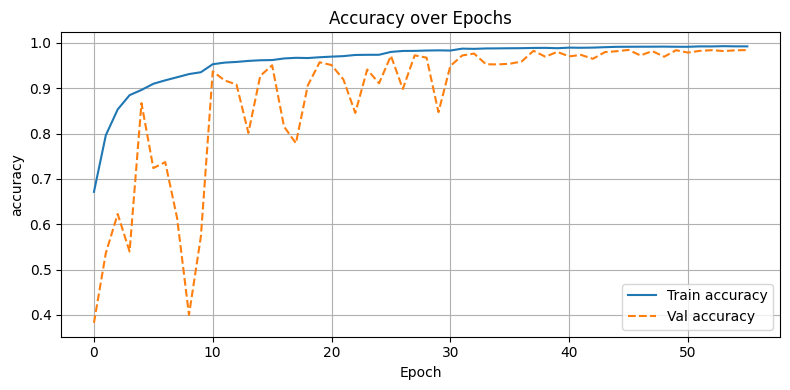

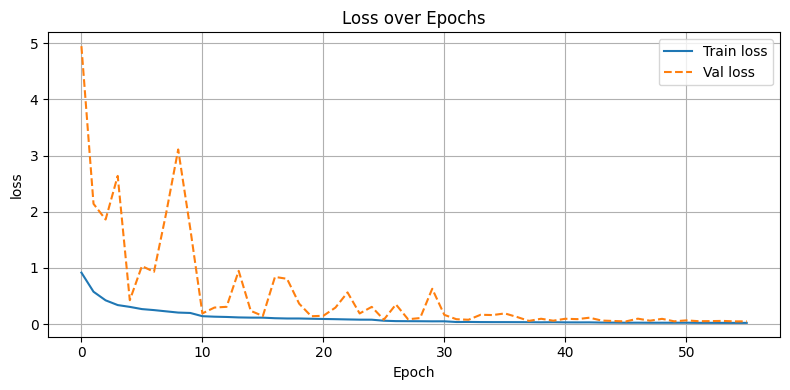

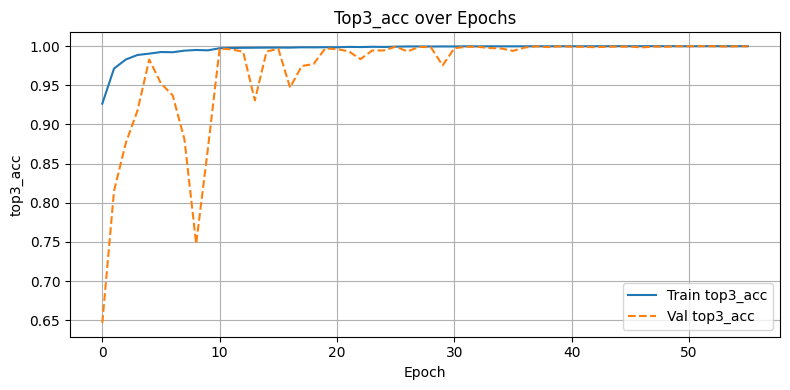

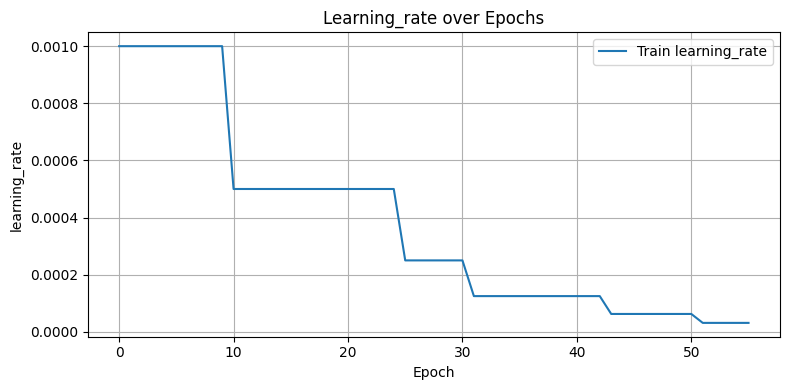

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step

=== Evaluation Results ===
loss: 0.5432
compile_metrics: 0.8981


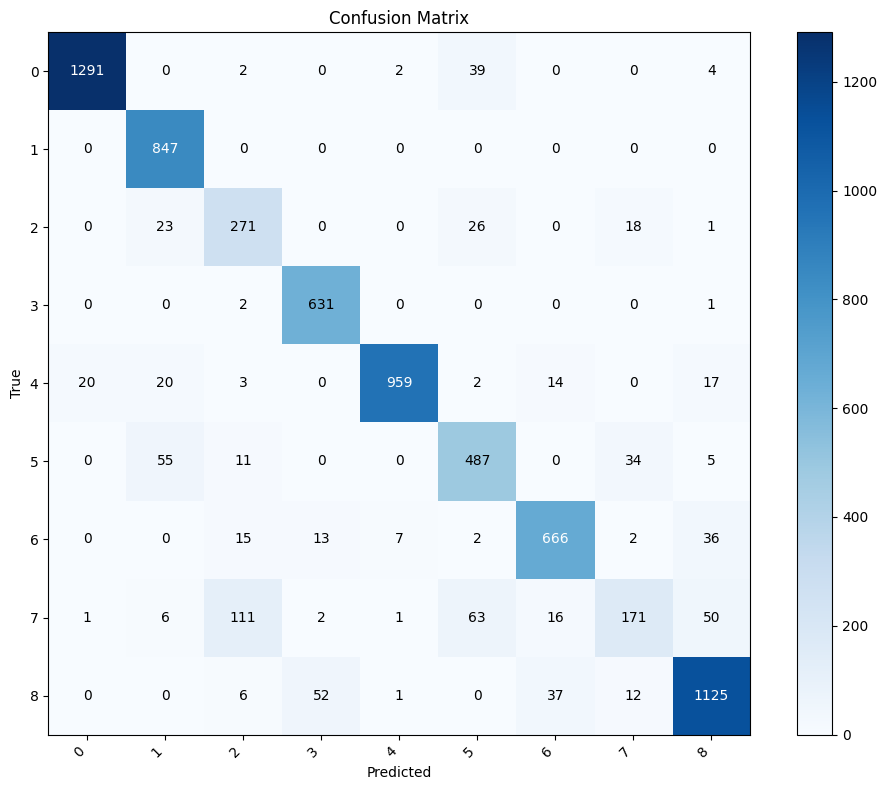


Classification Report:


,precision,recall,f1-score,support
0,0.98,0.96,0.97,1338.0
1,0.89,1.00,0.94,847.0
2,0.64,0.80,0.71,339.0
3,0.90,1.00,0.95,634.0
4,0.99,0.93,0.96,1035.0
5,0.79,0.82,0.80,592.0
6,0.91,0.90,0.90,741.0
7,0.72,0.41,0.52,421.0
8,0.91,0.91,0.91,1233.0
accuracy,0.90,0.90,0.90,0.9


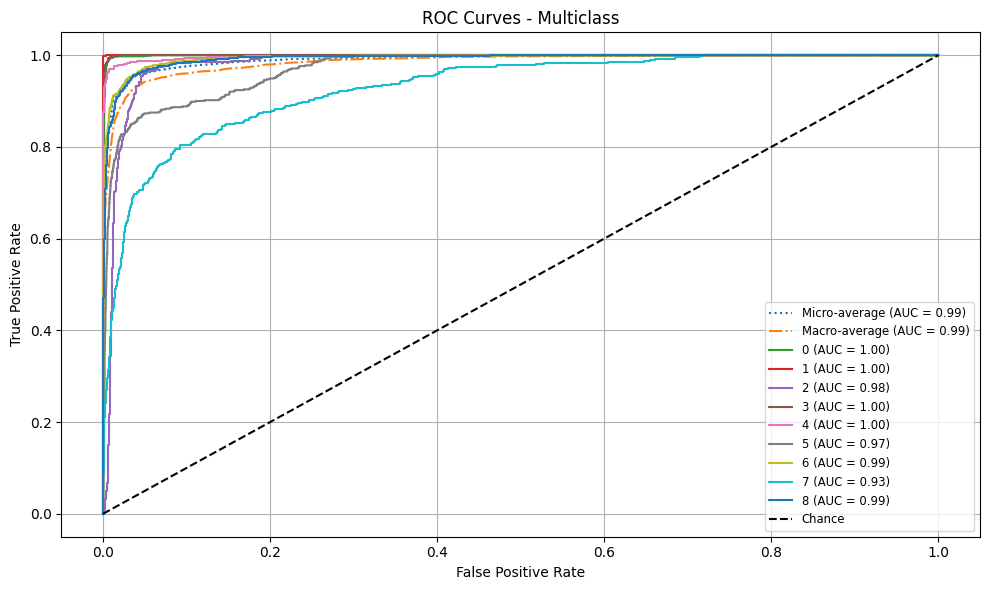

In [ ]:
def plot_history(history):
    for m in [m for m in history.history if not m.startswith("val_")]:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(history.history[m], label=f"Train {m}")
        val_key = f"val_{m}"
        if val_key in history.history:
            ax.plot(history.history[val_key], "--", label=f"Val {m}")
        ax.set_title(m.capitalize() + " over Epochs")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(m)
        ax.legend(loc="best")
        ax.grid(True)
        plt.tight_layout()
        plt.show()


def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, cmap="Blues")
    fig.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        ax.text(
            j,
            i,
            cm[i, j],
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.show()


def print_classification_report(y_true, y_pred, labels):
    rpt = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    df = pd.DataFrame(rpt).T.round(2)
    print("\nClassification Report:")
    display(df)


def plot_roc(y_true, y_prob, labels):
    from sklearn.preprocessing import label_binarize

    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob)
    labels = list(labels)
    present = np.unique(y_true)
    n_classes = len(labels)
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in present:
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in present]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in present:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(present)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10, 6))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        ":",
        label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
    )
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        "-.",
        label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
    )
    for i in present:
        plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Multiclass")
    plt.legend(loc="lower right", fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_history(history)

y_prob = model.predict(test_images, batch_size=batch_size)
y_pred = y_prob.argmax(axis=1)

results = model.evaluate(test_images, test_labels, verbose=0)
print("\n=== Evaluation Results ===")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

plot_confusion_matrix(test_labels, y_pred, info["label"])

print_classification_report(test_labels, y_pred, info["label"])

plot_roc(test_labels, y_prob, info["label"])